<a href="https://colab.research.google.com/github/gaokun227/fall_detection_project/blob/main/flair_training_using_health_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install flair
!pip install flair==0.4.0

     |████████████████████████████████| 70 kB 2.8 MB/s 
     |████████████████████████████████| 591.8 MB 640 bytes/s 
     |████████████████████████████████| 22.2 MB 1.4 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 12.8 MB 31.7 MB/s 
     |████████████████████████████████| 788 kB 37.9 MB/s 
     |████████████████████████████████| 117 kB 49.6 MB/s 
     |████████████████████████████████| 132 kB 49.4 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 8.6 MB 43.1 MB/s 
     |████████████████████████████████| 138 kB 47.3 MB/s 
     |████████████████████████████████| 127 kB 57.5 MB/s 
  Created wheel for flair: filename=flair-0.4.0-py3-none-any.whl size=78593 sha256=0c35662b1d4b7a02b750e8d4865172162bccc82259734ead63de209da22b1ff2
  Stored in directory: /root/.cache/pip/wheels/ee/db/cf/04677269cfbf6088d5d6fa89d989d818be68b86ef78fb47c89
  Created wheel for gensim: filename=gensim-3.4.0-

In [ ]:
# Mount google drive on the runtime
from google.colab import drive
drive.mount('/content/drive')
! ls drive/MyDrive/BD4H_project/

Mounted at /content/drive
data  embedding


In [ ]:
# Load packages and define functions
import numpy as np
import flair
import gensim
import pandas as pd
import unicodedata

from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data import Sentence, TaggedCorpus

#from flair.embeddings import NILCEmbeddings

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def tokenizer(text):
    return_text = []
    sw_port = stopwords.words("portuguese")
    for sentence in text:
        reg_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        tokens = reg_tokenizer.tokenize(sentence)
        return_text.append(' '.join([remove_accents(w.lower()) for w in tokens if w not in sw_port]))
    return return_text

def getScores(y, yPred):
    return (accuracy_score(y, yPred), 
            precision_score(y, yPred), 
            recall_score(y, yPred),
            f1_score(y, yPred, average='micro'),
            f1_score(y, yPred, average='macro'),
            f1_score(y, yPred, average='binary'),
            roc_auc_score(y, yPred))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Read data 
quedas = pd.read_csv('drive/MyDrive/BD4H_project/data/training_data_1000.csv')#.drop_duplicates('Evolucao')
print(quedas.shape)

(1078, 34)


In [ ]:
# Pre-processing
tokens_set = tokenizer(quedas['Evolucao'].values)

sentences = []

for i, text in enumerate(tokens_set):
  sentence = Sentence(text, labels=str(quedas['Target'][i]), use_tokenizer=True)
  sentences.append(sentence)

ML part

In [ ]:
custom_embedding = WordEmbeddings('drive/MyDrive/BD4H_project/embedding/health_word2vec/health_word2vec_s300.model')

target_set = quedas['Target'].values

results = []

kfold_test = StratifiedKFold(n_splits=3)

for i, (train, test) in enumerate(kfold_test.split(target_set, target_set)): # first split: train set is 2/3 (roughtly 718), test set is 1/3 (roughly 360)
  print(len(train), len(test)) # gets 718, 360

  kfold_dev = StratifiedKFold(n_splits=10)
  for train, dev in kfold_dev.split(target_set[train], target_set[train]): # second split: train set further devided into train (9/10; roughly 646) and dev (1/10; roughly 72)
    break

  print(len(train), len(dev), len(test)) # gets 646, 72, 360
  
  corpus = TaggedCorpus([sentences[t] for t in train], [sentences[d] for d in dev], [sentences[e] for e in test]) # a list of 3 lists; sublist 1/2/3  - train/dev/test set

  label_dict = corpus.make_label_dictionary()
  
  word_embeddings = [custom_embedding,
                     #nilc_embedding,
                     #pt_embeddings,
                     #flair_embedding_forward, 
                     #flair_embedding_backward, 
                     #bert_embedding,
                    ]
  
  document_embeddings: DocumentLSTMEmbeddings = DocumentLSTMEmbeddings(word_embeddings,
                                                                       hidden_size=512,
                                                                       reproject_words=True,
                                                                       reproject_words_dimension=256
                                                                       )
    
  classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=False)
  
  trainer = ModelTrainer(classifier, corpus)

  trainer.train('health_word2vec_'+str(i)+'/', max_epochs=40)
  
  pred_set = []
  true_set = []
  for e in test:
    sentence = sentences[e]
    true_set.append(target_set[e])
    classifier.predict(sentence)
    pred_set.append(int(sentence.labels[0].value))

  a, p, r, fmi, fma, fb, roc = getScores(true_set,pred_set)
  results.append(fb)
  print (round(a,3), round(p,3), round(r,3), round(fmi,3), round(fma,3), round(fb,3), round(roc,3))
  
  #break
  
print(results)
print('Mean: ', np.mean(results), 'Std: ', np.std(results))

718 360
646 72 360
2022-04-02 01:56:42,329 ----------------------------------------------------------------------------------------------------
2022-04-02 01:56:42,334 Evaluation method: MICRO_F1_SCORE
2022-04-02 01:56:42,339 ----------------------------------------------------------------------------------------------------
2022-04-02 01:56:42,930 epoch 1 - iter 0/21 - loss 0.02330899
2022-04-02 01:56:43,930 epoch 1 - iter 2/21 - loss 0.02741704
2022-04-02 01:56:45,325 epoch 1 - iter 4/21 - loss 0.03159101
2022-04-02 01:56:46,749 epoch 1 - iter 6/21 - loss 0.02804500
2022-04-02 01:56:48,544 epoch 1 - iter 8/21 - loss 0.02647205
2022-04-02 01:56:49,910 epoch 1 - iter 10/21 - loss 0.02549883
2022-04-02 01:56:50,703 epoch 1 - iter 12/21 - loss 0.02525159
2022-04-02 01:56:51,231 epoch 1 - iter 14/21 - loss 0.02465038
2022-04-02 01:56:51,973 epoch 1 - iter 16/21 - loss 0.02431095
2022-04-02 01:56:52,715 epoch 1 - iter 18/21 - loss 0.02472308
2022-04-02 01:56:53,144 epoch 1 - iter 20/21 - l

Plot

Fold 0


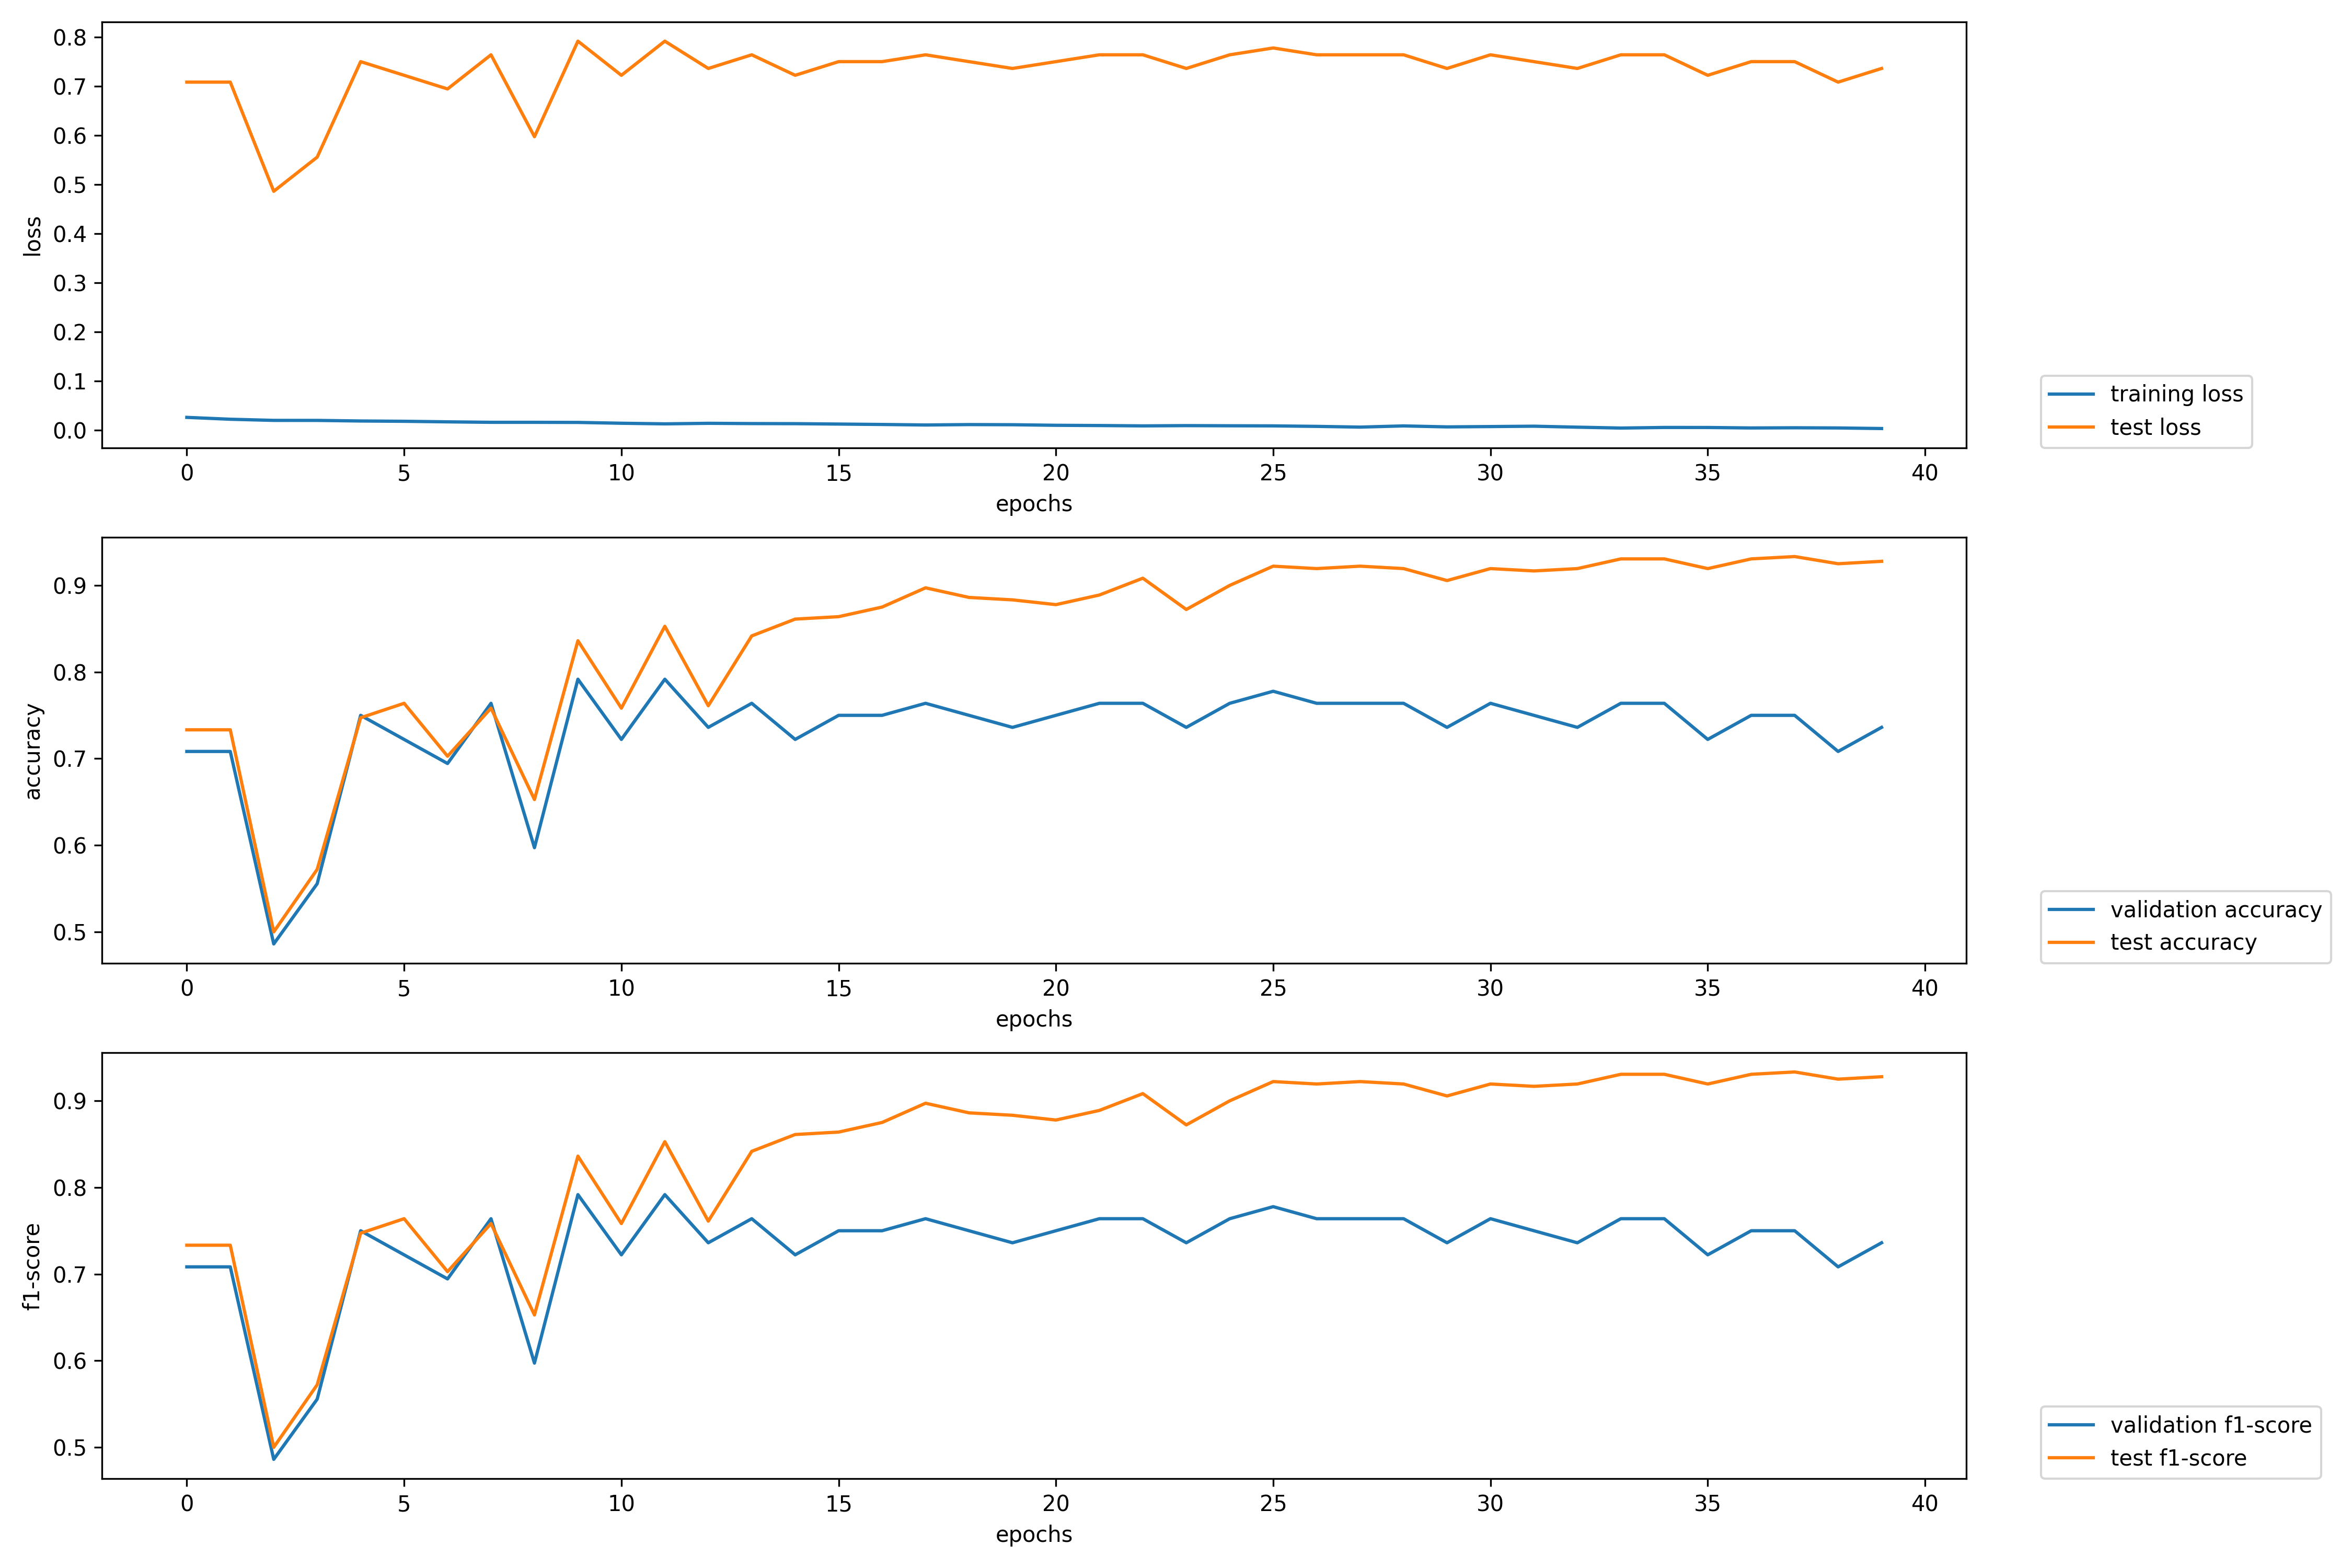

Fold 1


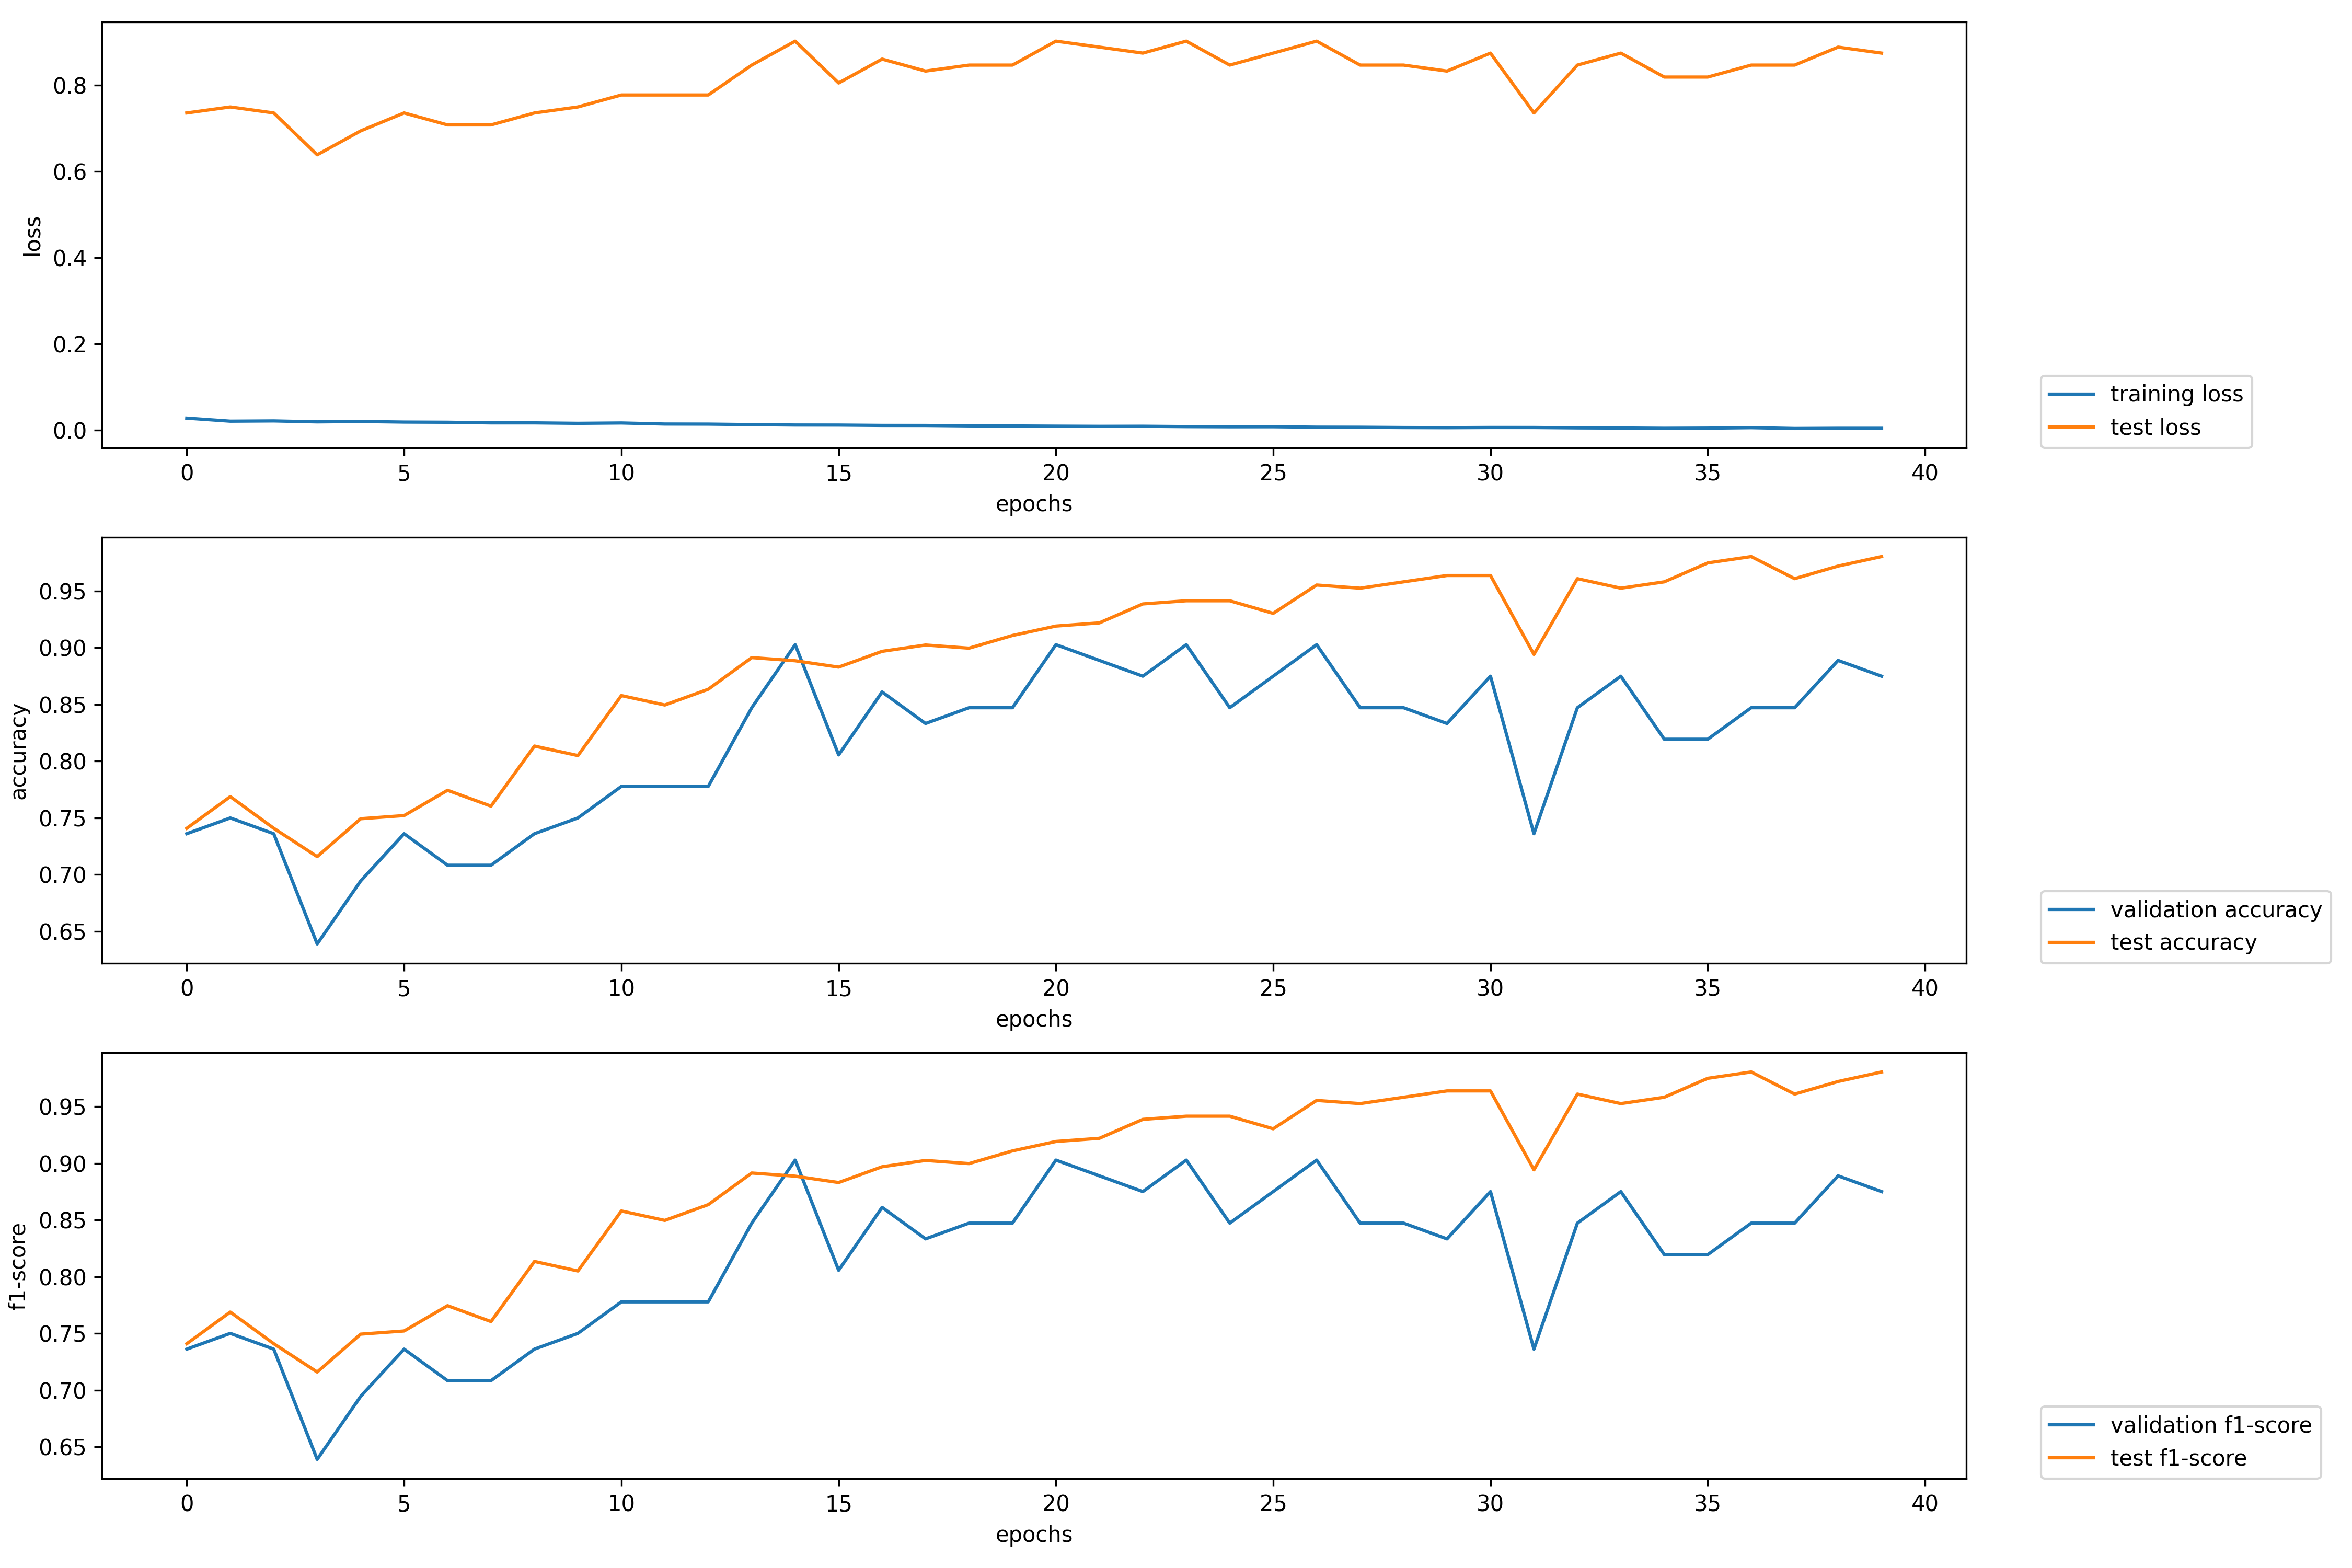

Fold 2


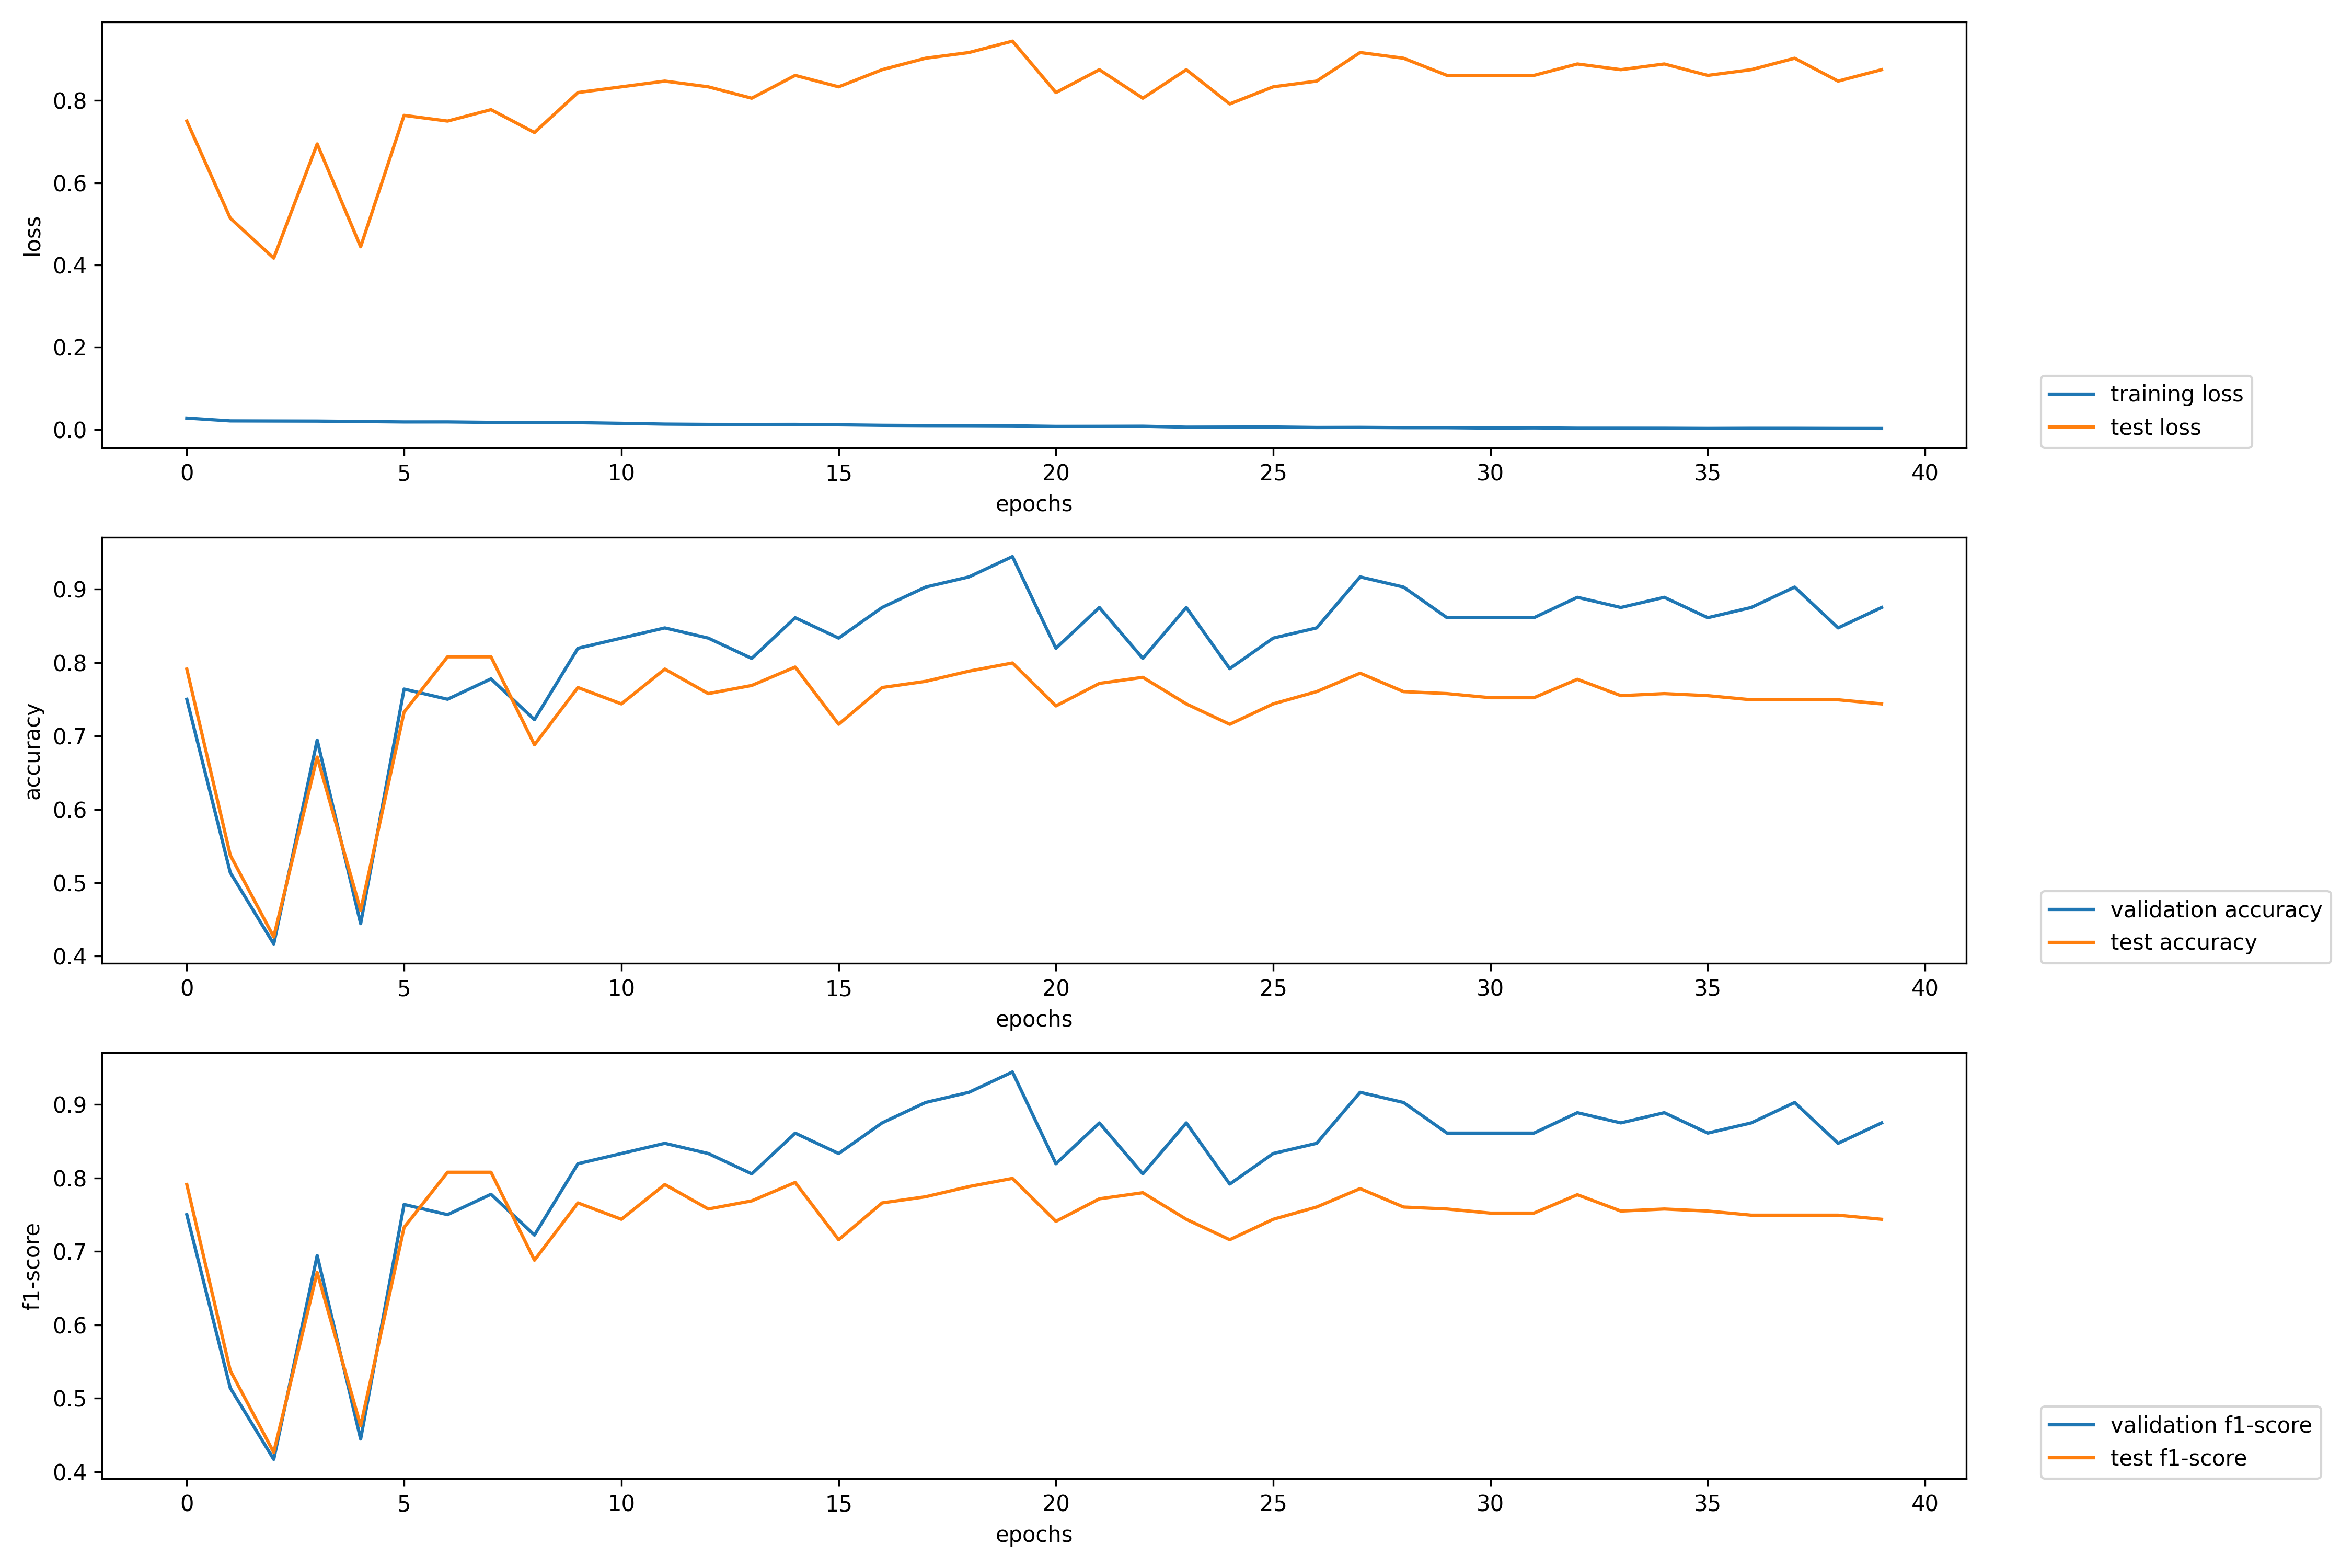

In [ ]:
from flair.visual.training_curves import Plotter
from IPython.display import Image, display
plotter = Plotter()

for i in range(3):
  plotter.plot_training_curves('quedas_'+str(i)+'/loss.tsv')
  #plotter.plot_weights('quedas_'+str(i)+'/weights.txt')
  print('Fold', i)
  display(Image('quedas_'+str(i)+'/training.png', width=900))
  #break